In [7]:



# !!!!Пока немного не доделано просьба не проверять !!!!

































# Домашняя работа

#    Подробнее описание и данные находятся в файле Practice_1_2.ipynb (вложение Материалы к занятию). 
#    Это задание мы разберем на следующем занятии в кампусе. 
#
#    Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, 
#    где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
#     
#    Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения 
#    клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается 
#    значение канала привлечения)
#
#    При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) 
#    необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:
#       - общая сумма транзакций по каждой из trx_category
#       - общая сумма транзакции по основным вылютам (напр. выделить рубли, 
#         доллары и евро - предположительно, это будут самые крупные категории)
#       - общая сумма транзакций по категориям MCC кодов (например, выбрать 
#         основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут 
#         быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; 
#         Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории 
#         кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
#       - возможные агрегации по времени суток и дням недели - траты в выходные 
#         (праздники) или будни, в ночное время или в рабочее и т.д.
#         
#    Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, 
#    выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, 
#    какие категории транзакции (trx_category) наиболее популярны и т.д. 
#    Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
#     
#    Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель 
#    (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном 
#    тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. 
#    Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
#     
#    Задания принимаются в виде ноутбука с кодов/картинками выполненной 
#    обязательной части + указанием места в leaderboard при решении дополнительной
#
#
#
#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [170]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [61]:
raw_df.channel_type.value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

In [62]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [63]:
raw_df[['cl_id','target_flag']].groupby('cl_id').mean().target_flag.value_counts()

1    2767
0    2233
Name: target_flag, dtype: int64

In [64]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [65]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  393931
Total transactions in test dataset:  96582


In [191]:
# Найдем самые популярные МСС коды
top_mcc = transactions_train[['MCC','cl_id']].groupby('MCC').count().sort_values('cl_id', ascending=False).head(30).index.tolist()
top_mcc[:10]

[5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921]

In [179]:
#def transaction_by_day_count(dataset):
#    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
#    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
#    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
#    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
#    return tmp_df
#def transaction_by_hour_count(dataset):
#    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
#    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

# Добавление параметров в датасет

# день недели транзакции
def add_day(dataset):
    dataset['day'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') )

# час суток транзакции      
def add_hour(dataset):
    dataset['hour'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') )



    
# приход и выход денег ( разделим по типам транзакции 
# в приход пойдут  типы 'DEPOSIT', 'CASH_ADV' , 'C2C_IN',  'BACK_TRX'
# в выход идут 'C2C_OUT' 'CAT' 'POS'  'WD_ATM_OTHER' 'WD_ATM_PARTNER' 'WD_ATM_ROS')
trx_category_in = ['DEPOSIT', 'CASH_ADV' , 'C2C_IN',  'BACK_TRX']

def add_is_IN_column(dataset):
    dataset['is_IN'] = dataset['trx_category'].apply(lambda x: 1 if x in trx_category_in else 0)

def add_number_week(dataset): 
    dataset['week'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%W') )
    
def count_week(dataset)    
    

In [180]:
def add_new_param(dataset):
    add_hour(dataset)             # добавим час
    add_day(dataset)              # добавим день
    add_is_IN_column(dataset)     # добавим направление 
    add_number_week(dataset)      # добавим недели 

In [86]:
import seaborn as sns

In [146]:
tmp_fd_hour = raw_df[['trx_category','hour','amount']].groupby(['trx_category','hour']).count().unstack(0).fillna(0)

In [127]:
tmp_fd_day = raw_df[['trx_category','day','amount']].groupby(['trx_category','day']).count().unstack(0).fillna(0)

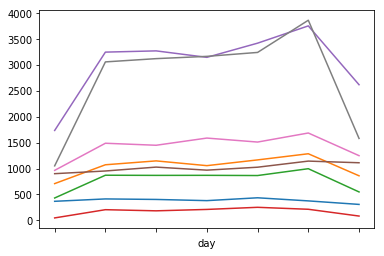

In [161]:
tmp_fd_day['amount'][['BACK_TRX','C2C_IN', 'C2C_OUT','CAT' ,'DEPOSIT','WD_ATM_OTHER','WD_ATM_PARTNER','WD_ATM_ROS']].plot(legend=False)

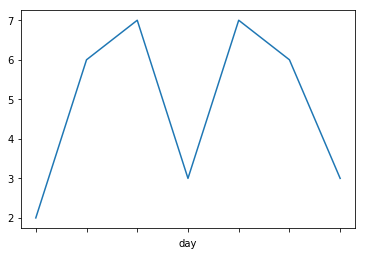

In [143]:
tmp_fd_day['amount'][['CASH_ADV']].plot(legend=False)

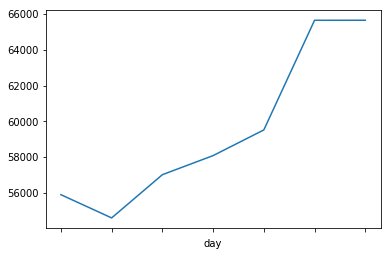

In [145]:
tmp_fd_day['amount'][['POS']].plot(legend=False)

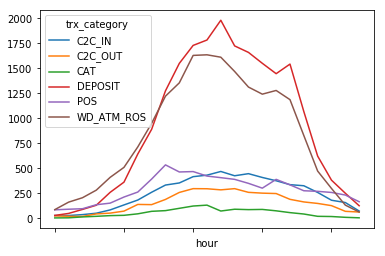

In [159]:
tmp_fd_hour[1:]['amount'][['C2C_IN','C2C_OUT', 'CAT','DEPOSIT' ,'POS','WD_ATM_ROS']].plot()

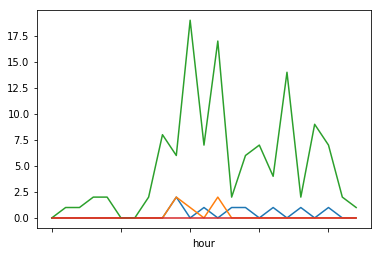

In [160]:
tmp_fd_hour[1:]['amount'][['BACK_TRX','CASH_ADV','WD_ATM_OTHER','WD_ATM_PARTNER']].plot(legend=False)

In [181]:
add_new_param(raw_df)

raw_df.head(1)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,hour,day,is_IN,week
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,00,6,0,42


In [168]:
## Генерация новых фич
"""
   Все функции возвращают датасет сгруппированные по cl_id 
"""

In [425]:

# Суммарные траты 
def all_amount(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[['cl_id', 'amount']].groupby('cl_id').sum() 

## Средние величины 
# В неделю 
def mean_week_in(dataset):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[['cl_id','week', 'amount']].groupby(['cl_id','week']).sum().reset_index().groupby('cl_id').mean().reset_index().rename(columns={'amount':'mean_week'})
# В выходные
def mean_weekend_out(dataset):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[dataset_cut['day'].isin([5, 6])][['cl_id','week', 'amount']].groupby(['cl_id','week']).sum().reset_index().groupby('cl_id').mean().reset_index().rename(columns={'amount':'mean_weekend'})
# В будни
def mean_weekdays_out(dataset):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[dataset_cut['day'].isin([1, 2, 3, 4])][['cl_id','week', 'amount']].groupby(['cl_id','week']).sum().reset_index().groupby('cl_id').mean().reset_index().rename(columns={'amount':'mean_weekend'})

# Траты по типам МСС (берем первые 30 типов отдельно, осталные в общее)
def amaunt_mcc_In_Out(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    
    df1_s = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).sum().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount').reset_index()
    for col in list(set(top_mcc) - set(df1_s.columns.values.tolist())):
        df1_s[col]=0
    df1_c = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).count().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount').reset_index()
    for col in list(set(top_mcc) - set(df1_c.columns.values.tolist())):
        df1_c[col]=0
    df1_m = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).mean().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount').reset_index()
    for col in list(set(top_mcc) - set(df1_m.columns.values.tolist())):
        df1_m[col]=0
    df2_s = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).sum().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'oder_sum'})
    df2_c = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).count().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'oder'})
    df2_m = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC']).mean().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'oder_mean'})
    
    df1_s = df1_s.merge(df1_m,  how='outer', on='cl_id',suffixes=('_sum','_mean') )
    df1_s = df1_s.merge(df1_c,  how='outer', on='cl_id')
    df2_s = df2_s.merge(df2_m, how='outer', on='cl_id')
    df2_s = df2_s.merge(df2_c, how='outer', on='cl_id')
    df = df1_s.merge(df2_s, how='outer', on='cl_id').fillna(0)
    return df

# количество транзакций по дням недели
def transaction_by_day_count(dataset):
    tmp_df = dataset.groupby(['cl_id','day'])['day'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

# количество транзакций по часам суток
def transaction_by_hour_count(dataset):
    return dataset.groupby(['cl_id','hour'])['hour'].size().unstack().fillna(0).reset_index()

# оборот по типам транзакции всего
def transaction_type_count(dataset):
    return dataset[['cl_id','trx_category','amount']].groupby(['cl_id','trx_category']).sum().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='trx_category', values='amount').reset_index()

# средний размер транзакции по типам 
def transaction_type_amount_mean(dataset): 
    return dataset[['cl_id','trx_category','amount']].groupby(['cl_id','trx_category']).mean().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='trx_category', values='amount').reset_index()



# среднее время между транзакциями 

def mean_time_between_transactions(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    res = pd.DataFrame([],columns=['cl_id', 'mean_delay'])
    for cl_id in dataset_cut['cl_id'].unique():
        temp_df = dataset[dataset['cl_id'] == cl_id]['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S'))).sort_values()
        df_1 = temp_df[:-1]
        df_2 = temp_df[1:]
        df_1 = pd.DataFrame(df1)
        df_2 = pd.DataFrame(df2)
        df_1.rename(columns={'TRDATETIME':'start'}, inplace=True)
        df_2.rename(columns={'TRDATETIME':'next'}, inplace=True) 
        df_3 = pd.concat([df1,df_2.reset_index().drop(columns=['index']) ],axis=1)
        df_3['dalay'] = df_3['next']-df_3['start']
        res.append([cl_id,(df_3['dalay'].mean()).seconds]) 
        print('id:',cl_id)
    return res                                                                     

def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [ ]:
raw_df.cl_id.unique()
df = raw_df['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))



In [426]:
mean_time_between_transactions(raw_df, 0)

id: 0
id: 1
id: 5
id: 9
id: 10
id: 11
id: 14
id: 20
id: 21
id: 22
id: 23
id: 24
id: 25
id: 28
id: 29
id: 31
id: 32
id: 35
id: 38
id: 39
id: 41
id: 42
id: 46
id: 48
id: 49
id: 50
id: 52
id: 54
id: 55
id: 56
id: 58
id: 59
id: 61
id: 63
id: 68
id: 69
id: 70
id: 73
id: 74
id: 76
id: 77
id: 78
id: 79
id: 81
id: 82
id: 84
id: 85
id: 88
id: 89
id: 90
id: 91
id: 93
id: 94
id: 96
id: 98
id: 100
id: 103
id: 104
id: 106
id: 107
id: 108
id: 109
id: 113
id: 114
id: 117
id: 119
id: 122
id: 124
id: 126
id: 129
id: 130
id: 132
id: 134
id: 136
id: 137
id: 138
id: 139
id: 141
id: 142
id: 143
id: 144
id: 148
id: 149
id: 152
id: 153
id: 154
id: 157
id: 160
id: 162
id: 163
id: 166
id: 168
id: 169
id: 177
id: 178
id: 180
id: 181
id: 183
id: 184
id: 186
id: 187
id: 190
id: 196
id: 198
id: 200
id: 204
id: 205
id: 206
id: 207
id: 211
id: 215
id: 216
id: 217
id: 219
id: 221
id: 224
id: 225
id: 227
id: 228
id: 229
id: 230
id: 235
id: 237
id: 239
id: 241
id: 242
id: 243
id: 247
id: 249
id: 250
id: 252
id: 253
id:

id: 2006
id: 2007
id: 2011
id: 2012
id: 2013
id: 2014
id: 2017
id: 2018
id: 2019
id: 2020
id: 2021
id: 2023
id: 2026
id: 2027
id: 2030
id: 2031
id: 2038
id: 2040
id: 2043
id: 2044
id: 2046
id: 2045
id: 2047
id: 2052
id: 2055
id: 2056
id: 2062
id: 2063
id: 2064
id: 2065
id: 2066
id: 2068
id: 2071
id: 2072
id: 2073
id: 2076
id: 2078
id: 2080
id: 2083
id: 2085
id: 2086
id: 2087
id: 2089
id: 2093
id: 2096
id: 2098
id: 2100
id: 2101
id: 2103
id: 2106
id: 2107
id: 2102
id: 2112
id: 2113
id: 2114
id: 2115
id: 2116
id: 2119
id: 2123
id: 2125
id: 2126
id: 2127
id: 2128
id: 2129
id: 2131
id: 2121
id: 2135
id: 2137
id: 2140
id: 2142
id: 2143
id: 2145
id: 2148
id: 2149
id: 2150
id: 2155
id: 2157
id: 2158
id: 2160
id: 2163
id: 2166
id: 2168
id: 2174
id: 2175
id: 2176
id: 2177
id: 2179
id: 2188
id: 2190
id: 2191
id: 2192
id: 2193
id: 2196
id: 2199
id: 2201
id: 2208
id: 2209
id: 2210
id: 2212
id: 2215
id: 2216
id: 2217
id: 2223
id: 2224
id: 2226
id: 2227
id: 2228
id: 2229
id: 2231
id: 2233
id: 2234
i

id: 3844
id: 3846
id: 3851
id: 3852
id: 3853
id: 3854
id: 3855
id: 3857
id: 3858
id: 3859
id: 3860
id: 3861
id: 3863
id: 3864
id: 3868
id: 3871
id: 3875
id: 3877
id: 3880
id: 3881
id: 3882
id: 3883
id: 3884
id: 3885
id: 3887
id: 3891
id: 3894
id: 3895
id: 3896
id: 3899
id: 3900
id: 3901
id: 3904
id: 3906
id: 3907
id: 3911
id: 3912
id: 3913
id: 3914
id: 3917
id: 3918
id: 3919
id: 3922
id: 3925
id: 3928
id: 3929
id: 3930
id: 3932
id: 3934
id: 3935
id: 3937
id: 3943
id: 3944
id: 3945
id: 3953
id: 3954
id: 3956
id: 3957
id: 3958
id: 3959
id: 3961
id: 3965
id: 3968
id: 3969
id: 3972
id: 3973
id: 3977
id: 3979
id: 3981
id: 3982
id: 3984
id: 3985
id: 3986
id: 3988
id: 3992
id: 3997
id: 3998
id: 4000
id: 4003
id: 4004
id: 4005
id: 4008
id: 4009
id: 4012
id: 4014
id: 4017
id: 4023
id: 4026
id: 4025
id: 4028
id: 4029
id: 4031
id: 4032
id: 4033
id: 4035
id: 4036
id: 4037
id: 4039
id: 4040
id: 4041
id: 4042
id: 4043
id: 4045
id: 4049
id: 4050
id: 4051
id: 4058
id: 4059
id: 4060
id: 4061
id: 4062
i

id: 5668
id: 5684
id: 5685
id: 5688
id: 5690
id: 5695
id: 5696
id: 5697
id: 5700
id: 5702
id: 5705
id: 5707
id: 5709
id: 5712
id: 5715
id: 5714
id: 5719
id: 5723
id: 5724
id: 5725
id: 5729
id: 5730
id: 5731
id: 5734
id: 5733
id: 5737
id: 5738
id: 5743
id: 5744
id: 5745
id: 5735
id: 5748
id: 5755
id: 5751
id: 5758
id: 5760
id: 5761
id: 5762
id: 5764
id: 5767
id: 5776
id: 5778
id: 5780
id: 5782
id: 5786
id: 5790
id: 5791
id: 5781
id: 5793
id: 5795
id: 5797
id: 5798
id: 5801
id: 5804
id: 5805
id: 5794
id: 5807
id: 5808
id: 5809
id: 5811
id: 5812
id: 5813
id: 5815
id: 5821
id: 5822
id: 5825
id: 5826
id: 5828
id: 5832
id: 5835
id: 5837
id: 5838
id: 5841
id: 5842
id: 5844
id: 5846
id: 5847
id: 5848
id: 5850
id: 5851
id: 5855
id: 5858
id: 5860
id: 5862
id: 5866
id: 5867
id: 5871
id: 5872
id: 5873
id: 5877
id: 5878
id: 5881
id: 5884
id: 5889
id: 5890
id: 5892
id: 5896
id: 5897
id: 5902
id: 5904
id: 5907
id: 5908
id: 5909
id: 5913
id: 5915
id: 5916
id: 5917
id: 5920
id: 5921
id: 5925
id: 5926
i

id: 7655
id: 7659
id: 7660
id: 7663
id: 7665
id: 7671
id: 7673
id: 7680
id: 7681
id: 7683
id: 7684
id: 7688
id: 7690
id: 7698
id: 7701
id: 7702
id: 7703
id: 7705
id: 7706
id: 7707
id: 7708
id: 7709
id: 7713
id: 7714
id: 7715
id: 7717
id: 7721
id: 7722
id: 7723
id: 7724
id: 7725
id: 7726
id: 7727
id: 7732
id: 7733
id: 7736
id: 7737
id: 7738
id: 7739
id: 7740
id: 7742
id: 7745
id: 7746
id: 7747
id: 7748
id: 7752
id: 7751
id: 7731
id: 7757
id: 7762
id: 7769
id: 7771
id: 7773
id: 7774
id: 7775
id: 7777
id: 7778
id: 7779
id: 7780
id: 7782
id: 7786
id: 7787
id: 7788
id: 7791
id: 7797
id: 7799
id: 7801
id: 7803
id: 7805
id: 7810
id: 7811
id: 7809
id: 7814
id: 7815
id: 7816
id: 7817
id: 7818
id: 7820
id: 7821
id: 7822
id: 7824
id: 7825
id: 7828
id: 7829
id: 7806
id: 7830
id: 7831
id: 7833
id: 7834
id: 7835
id: 7836
id: 7842
id: 7840
id: 7847
id: 7844
id: 7849
id: 7850
id: 7855
id: 7856
id: 7858
id: 7859
id: 7861
id: 7838
id: 7863
id: 7864
id: 7869
id: 7870
id: 7871
id: 7867
id: 7876
id: 7862
i

id: 9506
id: 9507
id: 9508
id: 9509
id: 9510
id: 9515
id: 9516
id: 9519
id: 9521
id: 9522
id: 9523
id: 9524
id: 9530
id: 9531
id: 9532
id: 9533
id: 9534
id: 9536
id: 9539
id: 9541
id: 9543
id: 9545
id: 9546
id: 9548
id: 9551
id: 9552
id: 9554
id: 9557
id: 9560
id: 9561
id: 9562
id: 9564
id: 9565
id: 9567
id: 9568
id: 9572
id: 9574
id: 9582
id: 9584
id: 9587
id: 9591
id: 9593
id: 9598
id: 9600
id: 9601
id: 9602
id: 9603
id: 9606
id: 9607
id: 9608
id: 9609
id: 9611
id: 9614
id: 9616
id: 9619
id: 9620
id: 9623
id: 9627
id: 9630
id: 9632
id: 9633
id: 9634
id: 9636
id: 9637
id: 9638
id: 9639
id: 9642
id: 9643
id: 9645
id: 9647
id: 9648
id: 9651
id: 9656
id: 9657
id: 9658
id: 9663
id: 9667
id: 9670
id: 9673
id: 9674
id: 9675
id: 9676
id: 9678
id: 9679
id: 9680
id: 9684
id: 9685
id: 9687
id: 9689
id: 9690
id: 9691
id: 9692
id: 9693
id: 9694
id: 9698
id: 9701
id: 9702
id: 9704
id: 9705
id: 9706
id: 9708
id: 9710
id: 9712
id: 9715
id: 9716
id: 9718
id: 9719
id: 9722
id: 9724
id: 9725
id: 9726
i

,cl_id,mean_delay


In [392]:
df1 = df[:-1]
df2 = df[1:]


In [393]:
df1 = pd.DataFrame(df1)
df2 = pd.DataFrame(df2)

In [396]:
df1.rename(columns={'TRDATETIME':'start'}, inplace=True)
df2.rename(columns={'TRDATETIME':'next'}, inplace=True)


In [397]:
df1.head()

,start
0,2017-10-21 00:00:00
1,2017-10-12 12:24:07
2,2017-12-05 00:00:00
3,2017-10-21 00:00:00
4,2017-10-24 13:14:24


In [398]:
df3 = pd.concat([df1,df2.reset_index().drop(columns=['index']) ],axis=1)

In [406]:
df3['dalay'] = df3['next']-df3['start']
df3['dalay']

0          -9 days +12:24:07
1           53 days 11:35:53
2         -45 days +00:00:00
3            3 days 13:14:24
4          -9 days +10:45:36
5          -6 days +00:00:00
6            6 days 00:00:00
7          -5 days +00:00:00
8         -77 days +00:00:00
9           66 days 00:00:00
10        -59 days +00:00:00
11          60 days 00:00:00
12        -62 days +00:00:00
13          69 days 00:00:00
14           6 days 00:00:00
15        -28 days +00:00:00
16           5 days 00:00:00
17        -59 days +00:00:00
18          64 days 00:00:00
19         -7 days +00:00:00
20           8 days 00:00:00
21         -7 days +00:00:00
22           7 days 00:00:00
23        -43 days +00:00:00
24          49 days 00:00:00
25         -5 days +00:00:00
26           4 days 00:00:00
27        -26 days +00:00:00
28          26 days 00:00:00
29        -28 days +00:00:00
                 ...        
490482     -8 days +09:01:53
490483      43 days 14:58:07
490484     194 days 11:29:38
490485       0

In [407]:
(df3['dalay'].mean()).seconds

86377

In [441]:
df = pd.DataFrame(columns=['cl_id', 'mean_delay'])
df.columns.values

array(['cl_id', 'mean_delay'], dtype=object)

In [434]:
df.append(pd.DataFrame([1,1], columns=['cl_id', 'mean_delay']))

ValueError: Shape of passed values is (1, 2), indices imply (2, 2)